In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import torch

In [16]:
df = pd.read_csv("Datos_Portadas.csv")
data = pd.DataFrame(df)
print(data.describe())

              year   cant_notas     politica         roja     deporte  \
count  5770.000000  5770.000000  5770.000000  5770.000000  5769.00000   
mean   2022.995494     3.867764     0.057886     0.368631     0.50702   
std       0.826402     0.665379     0.272590     0.710338     0.58943   
min    2022.000000     0.000000     0.000000     0.000000     0.00000   
25%    2022.000000     4.000000     0.000000     0.000000     0.00000   
50%    2023.000000     4.000000     0.000000     0.000000     0.00000   
75%    2024.000000     4.000000     0.000000     1.000000     1.00000   
max    2025.000000     6.000000     4.000000     5.000000     3.00000   

         accidente  comunitaria   nacionales  internacional  modelo_portada  \
count  5770.000000  5770.000000  5770.000000    5770.000000     5770.000000   
mean      0.389948     2.278683     0.239168       0.028769        0.008666   
std       0.624598     1.321180     0.618929       0.177238        0.092693   
min       0.000000     0.0

In [17]:
spanish_stopwords = [
    "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las",
    "por", "un", "para", "con", "no", "una", "su", "al", "es", "lo",
    "como", "más", "pero", "sus", "le", "ya", "o", "fue", "me", "si",
    "sin", "sobre", "este", "ya", "también", "entre", "cuando", "uno", "dos",
    "tres", "cuatro", "cinco", "seis", "siete", "ocho", "nueve", "mas", "diez", "1",
    "2", "3", "4", "5", "6", "7", "8", "9", "10", "11","12", "13", "14", "15", "16",
    "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30",
    "aã", "tras", "mil", "anos", "tras", "niã", "son", "contra", "fueron", "hasta",
    "queda", "hasta", "os", "sera", "durante", "van", "han", "q1", "q2", "q3", "q4", "q5", "q6",
    "q7", "q8", "q9", "q10", "deja", "ante", "han", "estan", "pierde", "ha", "dia", "50", "2022",
    "desde", "despues", "ano", "dias", "otra", "luego", "km", "pedro", "2024", "2025", "2023", "hace",
    "donde", "otro", "daã", "iba", "les", "dan", "45", "tienen", "hacen", "juan"
]

vectorizer = CountVectorizer(max_features=5000, stop_words=spanish_stopwords)

In [18]:
# Fill NaN values with an empty string
data["titulo"] = data["titulo"].fillna("").astype(str)
data["subtitular"] = data["subtitular"].fillna("").astype(str)

data["text"] = data["titulo"] + " " + data["subtitular"]

In [19]:
# Download Spanish stopwords (only needed once)
#nltk.download("stopwords")
#spanish_stopwords = stopwords.words("spanish")

# Define range of parameters to test
n_components_range = [5, 10, 15, 20]  # Example LDA n_components values
num_classes_range = [5, 10, 15, 20]  # Example LCA num_classes values

# Prepare an empty list to store the latent class distributions
distributions = []

for n_components in n_components_range:
    for num_classes in num_classes_range:
        # Apply LDA with Spanish stop words
        vectorizer = CountVectorizer(max_features=5000, stop_words=spanish_stopwords)
        X = vectorizer.fit_transform(data["text"])

        lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
        X_topics = lda.fit_transform(X)
        data["topic"] = X_topics.argmax(axis=1)

        # Apply OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False)
        X_lca = encoder.fit_transform(data[["topic"]])

        # Apply LCA (GaussianMixture)
        lca_model = GaussianMixture(n_components=num_classes, covariance_type="full", random_state=42)
        data["latent_class"] = lca_model.fit_predict(X_lca)

        # Calculate class distribution
        class_distribution = data["latent_class"].value_counts().values
        distributions.append([n_components, num_classes, class_distribution])

# Convert results into a DataFrame for visualization
distributions_df = pd.DataFrame(distributions, columns=["n_components", "num_classes", "class_distribution"])

# Make sure all classes are represented in each distribution
distributions_df["class_count"] = distributions_df["class_distribution"].apply(lambda x: np.sum(x))


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/ho

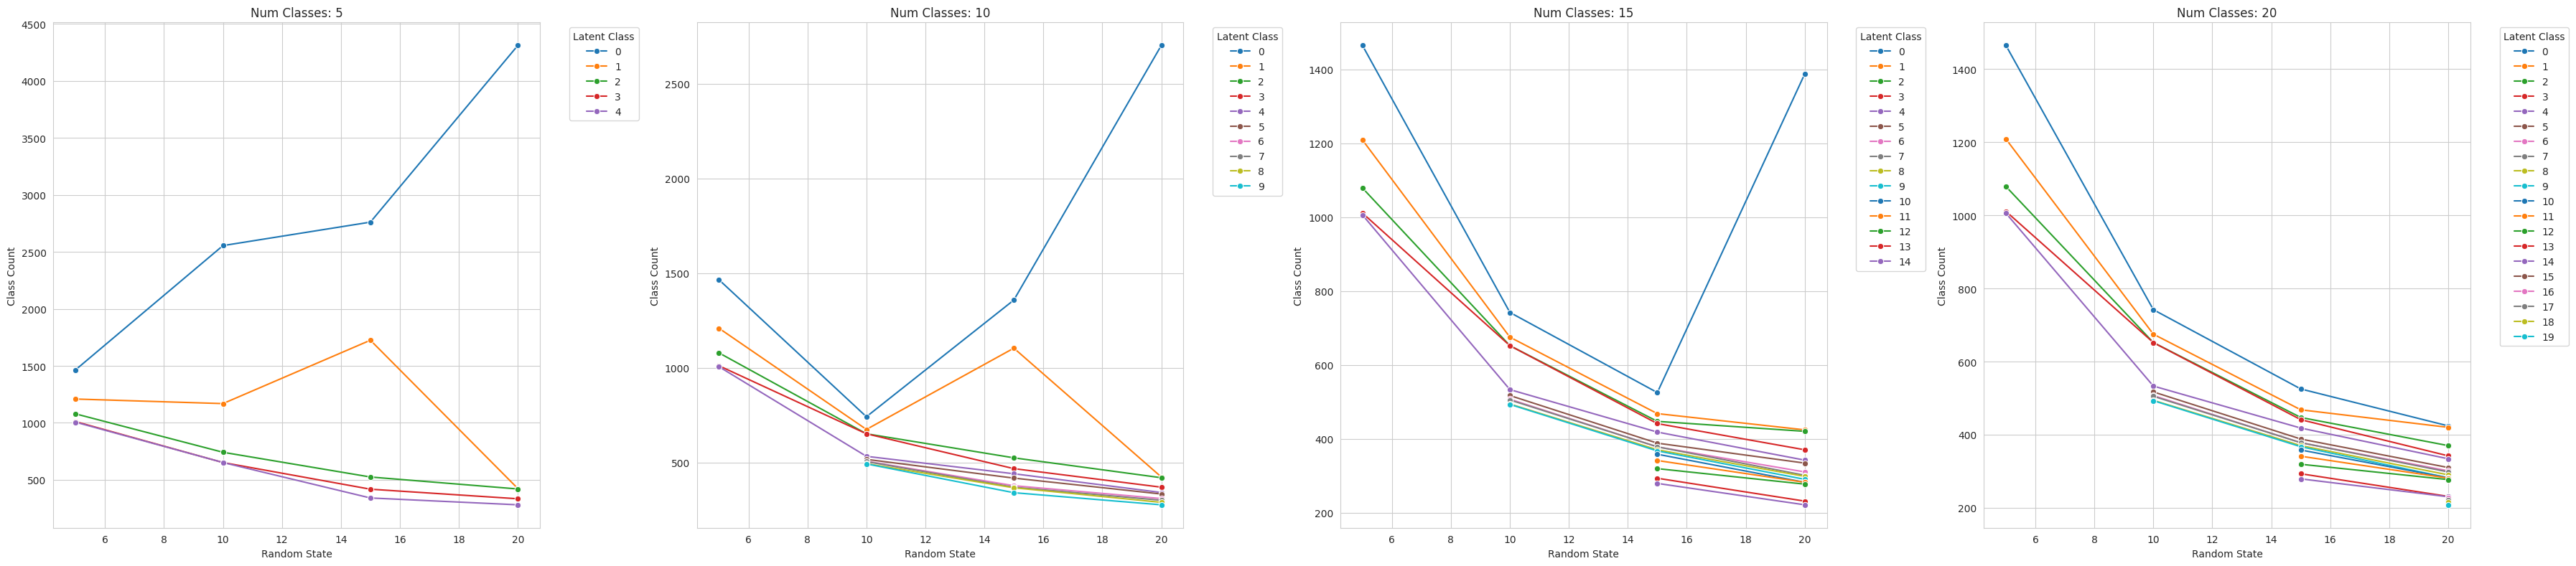

In [20]:
# Define a broader range of random states (e.g., 20 values between 0 and 3000)
random_state_range = np.linspace(0, 3000, dtype=int)

# Convert class distributions into DataFrame
plot_data = []

for entry in distributions:
    random_state, num_classes, class_distribution = entry  # Ensure distributions include random_state
    for class_idx, count in enumerate(class_distribution):
        plot_data.append([random_state, num_classes, class_idx, count])

# Create DataFrame
plot_df = pd.DataFrame(plot_data, columns=["random_state", "num_classes", "class_idx", "count"])

# Plot distributions for each num_classes set
plt.figure(figsize=(36, 8))
sns.set_style("whitegrid")

for idx, num_classes in enumerate(num_classes_range):
    plt.subplot(1, len(num_classes_range), idx + 1)
    subset = plot_df[plot_df["num_classes"] == num_classes]
    sns.lineplot(
        x="random_state", y="count", hue="class_idx", data=subset, marker="o", palette="tab10"
    )
    plt.title(f"Num Classes: {num_classes}")
    plt.xlabel("Random State")
    plt.ylabel("Class Count")
    plt.legend(title="Latent Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

plt.show()

In [21]:
bics = []
aics = []
class_range = range(2, 30)  # Try between 2 and 10 classes

for n in class_range:
    gmm = GaussianMixture(n_components=19, covariance_type="tied", random_state=50)
    gmm.fit(X_lca)
    bics.append(gmm.bic(X_lca))
    aics.append(gmm.aic(X_lca))

bic_scores = class_range[np.argmin(bics)]
print(f"Optimal number of classes based on BIC: {bic_scores}")


Optimal number of classes based on BIC: 2


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (21). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (23). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


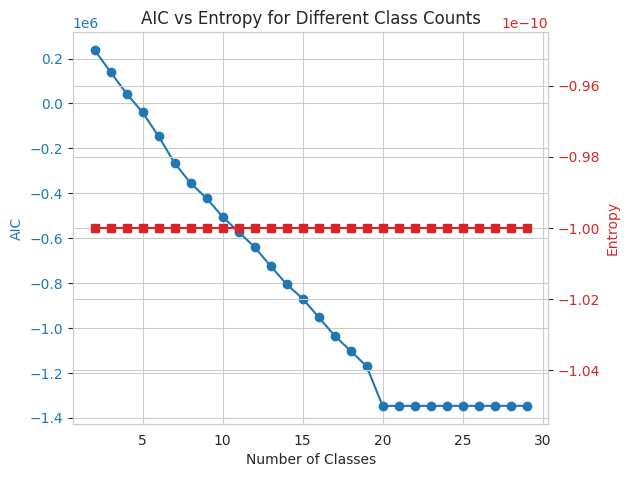

In [22]:
# Standardize data
scaler = StandardScaler()
X_lca_scaled = scaler.fit_transform(X_lca)

# Define range of latent classes to test
class_range = range(2, 30)  # Try between 2 and 30 classes

# Store results
aic_scores = []
entropy_scores = []

def entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1).mean()

for n in class_range:
    lca_model = GaussianMixture(n_components=n, covariance_type="spherical", init_params="kmeans", random_state=25)
    lca_model.fit(X_lca_scaled)

    # Compute AIC
    aic_scores.append(lca_model.aic(X_lca_scaled))

    # Compute Entropy
    class_probs = lca_model.predict_proba(X_lca_scaled)
    entropy_scores.append(entropy(class_probs))

# Plot AIC and Entropy
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Classes")
ax1.set_ylabel("AIC", color="tab:blue")
ax1.plot(class_range, aic_scores, marker="o", color="tab:blue", label="AIC")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Entropy", color="tab:red")
ax2.plot(class_range, entropy_scores, marker="s", color="tab:red", label="Entropy")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.tight_layout()
plt.title("AIC vs Entropy for Different Class Counts")
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_lca_scaled = scaler.fit_transform(X_lca)

# Define number of latent classes
num_classes = 12

# Fit LCA model using Gaussian Mixture Model (GMM)
lca_model = GaussianMixture(n_components=num_classes, covariance_type="spherical", init_params="kmeans", random_state=25)
data["latent_class"] = lca_model.fit_predict(X_lca)

# Check class distribution
print(data["latent_class"].value_counts())

latent_class
4     1499
0     1046
1      424
2      420
3      342
11     310
7      301
5      298
10     290
9      282
6      281
8      277
Name: count, dtype: int64


In [24]:
def entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1).mean()

class_probs = lca_model.predict_proba(X_lca)
print("LCA Model Entropy:", entropy(class_probs))

# Get AIC value
aic_value = lca_model.aic(X_lca_scaled)
print(f"AIC: {aic_value}")

LCA Model Entropy: 0.022294073821221224
AIC: 2644312.3420663676


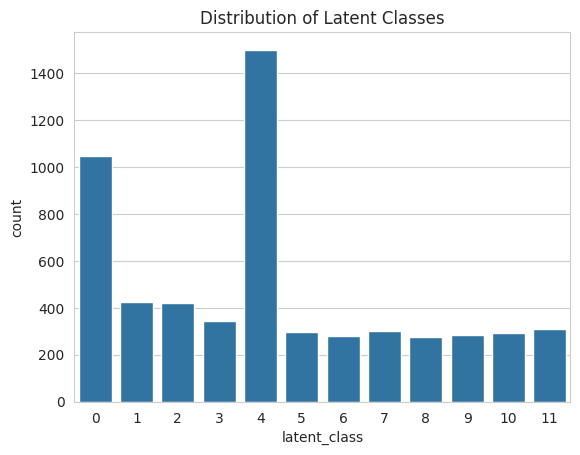

In [25]:
sns.countplot(x=data["latent_class"])
plt.title("Distribution of Latent Classes")
plt.show()

In [26]:
print(data.groupby("latent_class")["topic"].value_counts())

latent_class  topic
0             12       370
              13       231
              16       230
              4        215
1             19       424
2             7        420
3             3        342
4             11       334
              5        282
              2        227
              10       227
              14       221
              18       208
5             8        298
6             1        281
7             0        301
8             17       277
9             6        282
10            9        290
11            15       310
Name: count, dtype: int64


In [27]:
# Function to extract top words per topic without duplication
def get_top_words_unique(lda_model, feature_names, num_words=50):
    topic_keywords = {}
    used_keywords = set()  # Keep track of already used keywords
    for topic_idx, topic in enumerate(lda_model.components_):
        top_keywords = []
        for i in topic.argsort()[-num_words:]:
            keyword = feature_names[i]
            if keyword not in used_keywords:
                top_keywords.append(keyword)
                used_keywords.add(keyword)
        
        # Ensure we have enough unique keywords, if not, add more from the remaining options
        if len(top_keywords) < num_words:
            for i in topic.argsort()[:-num_words-1:-1]:
                keyword = feature_names[i]
                if keyword not in used_keywords:
                    top_keywords.append(keyword)
                    used_keywords.add(keyword)
        
        topic_keywords[topic_idx] = top_keywords
    return topic_keywords

# Get words for each topic ensuring no duplication
topic_keywords = get_top_words_unique(lda, feature_names)

# Display top words per topic
for topic, words in topic_keywords.items():
    print(f"Topic {topic}: {', '.join(words)}")



NameError: name 'feature_names' is not defined

In [ ]:
probs = lca_model.predict_proba(X_lca_scaled)
print(probs.min(), probs.max())

0.0 1.0


# Esta es la conexion del modelo

In [ ]:
new_title = "colisionan y vuelcan"
new_subtitle = "familia se dirigia a vender al mercado"

# Merge text
new_text = new_title + " " + new_subtitle

# Transform into vector
X_new = vectorizer.transform([new_text])
X_new_topic = lda.transform(X_new).argmax(axis=1)  # Get topic

# Convert topic into categorical format
X_new_lca = encoder.transform([[X_new_topic[0]]])

# Predict latent class
predicted_class = lca_model.predict(X_new_lca)
print("Predicted Latent Class:", predicted_class[0])

Predicted Latent Class: 0


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


# FINAL

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define category-related keywords with weights
category_keywords = {
    "Religión y Tradición": ["tradicional", "cortejo", "nazareno", "mayor", "comienzan", "independencia", "imagen", "acompanan", "conmemoran", "patrona", "feligreses", "cuaresma", "recorre", "concepcion", "catolicos", "historico", "recorrido", "domingo", "mercado", "cientos", "estudiantes", "procesion", "antigua", "festejos", "participan", "preparan", "devotos", "fiestas", "actividades", "visitantes", "virgen", "celebran"],
    "Criminalidad y Violencia": ["cerca", "asesinato", "nina", "mecanico", "esperaron", "orfandad", "hermosa", "problema", "sicarios", "nino", "desconocidos", "atacan", "bala", "eeuu", "asesinan", "atacado", "balazos", "menor"],
    "Accidentes Viales": ["dirigia", "embestido", "salio", "familiares", "milagro", "hija", "murio", "frenos", "fallecio", "salvan", "hijos", "salen", "barranco", "carretera", "morir", "quedo", "amigos", "auto", "madre", "frente", "hondonada", "arrollado", "iban", "carro", "impacta", "choca", "metros", "cae"],
    "Proyectos de Infraestructura": ["santiago", "nuevo", "mareros", "fuerzas", "seguridad", "adultos", "herido", "mexico", "centro", "sale", "muerto", "hospital", "grave", "bus", "fiesta", "resultan", "victima", "regresaba", "heridos", "asalto", "pnc", "vehiculo", "sobrevive", "herida", "ser", "fuego", "accidente", "disparan", "mueren", "muere", "tragedia", "familia", "victimas", "armado", "ataque"],
    "Demandas Sociales": ["quedar", "sur", "ayuda", "casco", "sigue", "casi", "tierra", "construir", "drenaje", "pavimentacion", "zonas", "cierre", "via", "urbano", "podria", "reparacion", "invierno", "viven", "transporte", "colapsar", "comuna", "tramo", "proyecto", "reparan"],
    "Riesgos y Emergencias": ["afectadas", "provisional", "alternas", "perros", "afecta", "habilitan", "ocasiona", "vivienda", "punto", "complica", "vias", "villa", "ciudad", "hacia", "socavamiento", "carril", "barrio", "acceso", "derrumbe", "construccion", "dano", "desnivel", "hundimiento", "colapso", "kilometro"],
    "Inseguridad y Conflictos": ["carreteras", "camino", "fin", "siguen", "temen", "recibir", "guatemala", "falta", "pueden", "esta", "cosechas", "autoridades", "primera", "chimaltenango", "debido", "lago", "muro", "dejan", "coatepeque", "riesgo", "aldeas", "partido", "pierden", "derrumbes", "agricultores", "incendio", "semana", "paso", "afectan", "locales", "transportistas", "perdidas", "oficial", "nacional", "municipal", "millones", "evitar", "vehicular", "conductores", "peten", "ruta", "piden"],
    "Seguridad y Bienestar": ["viviendas", "lluvias", "costo", "guatemaltecos", "abandono", "rafael", "dios", "comerciantes", "seran", "comunidades", "vuelven", "jesus", "sufren", "todo", "salud", "casos", "fe", "vehiculos", "municipio", "reciben", "esperan", "centros", "menos", "personas", "ninos", "vendedores", "fieles", "devocion", "obra", "municipios", "horas", "llegar", "patrono", "agua", "antonio", "bloqueos", "trabajos", "flores", "familias", "miguel", "cada", "francisco", "afectados", "pobladores", "jose", "aldea", "vecinos", "marcos", "sacatepequez", "san"],
    "Desastres Naturales": ["tendran", "cayo", "final", "hallado", "pueblo", "capital", "descenso", "nivel", "arriesgan", "quebrada", "rural", "vez", "habitantes", "lluvia", "tratamiento", "mundo", "precio", "area", "afluente", "desborde", "julia", "planta", "residentes", "caudal", "crecida", "rios", "motagua"],
    "Accidentes y Tragedias": ["izabal", "puerto", "buscan", "tenia", "vecino", "agricultor", "despiden", "julio", "tormenta", "hectareas", "registran", "norte", "sido", "sepultan", "supuestos", "prevenir", "dejado", "mama", "ocurrido", "80", "joven", "pais", "forestales", "barrios", "departamento", "policia", "inundaciones", "asesinado", "incendios", "dengue"],
    "Crimenes": ["lleva", "turistas", "servicio", "caminan", "clandestinos", "cementerio", "christi", "temporada", "desfile", "honor", "patronal", "comunidad", "ana", "lugar", "tiene", "material", "pasado", "limpian", "tradicion", "mal", "calles", "estado", "basureros", "llevan", "contaminacion", "atencion", "exigen", "lodo", "negro", "toneladas", "cristo", "desechos", "feria", "basura"],
    "Educación y Salud Comunitaria": ["drenajes", "educativos", "solo", "labores", "instalaciones", "agresion", "sexual", "atienden", "docentes", "ninas", "colapsa", "negras", "aguas", "techo", "colision", "ciclo", "escolar", "pacientes", "aulas", "maestros", "padres", "alumnos", "clases", "escuela"],
}

# Convert category keywords into a feature vector
def get_weighted_features(text):
    words = text.lower().split()
    category_scores = {category: 0 for category in category_keywords}
    
    for category, keywords in category_keywords.items():
        for word in words:
            if word in keywords:
                category_scores[category] += 1  # Assign a weight based on word presence
    
    return np.array(list(category_scores.values()))

# Example usage
new_title = ""
new_subtitle = "reparacion negro pacientes aldea puente paso arrollado hombre muere hospital"
new_text = new_title + " " + new_subtitle
features = get_weighted_features(new_text)
print("Feature Vector:", features)

Feature Vector: [0 0 2 2 1 0 3 2 0 0 2 1]


In [30]:
# Function to Categorize New Texts

def categorize_new_texts(new_data, vectorizer, lda_model, lca_model, encoder):
    """
    Categorizes new newspaper texts based on trained LDA and LCA models.
    
    Parameters:
    new_data (pd.DataFrame): A DataFrame with "titulo" and "subtitular" columns.
    vectorizer (CountVectorizer): Trained CountVectorizer.
    lda_model (LatentDirichletAllocation): Trained LDA model.
    lca_model (GaussianMixture): Trained LCA model.
    encoder (OneHotEncoder): Trained encoder for LCA.

    Returns:
    pd.DataFrame: The new data with assigned topic and latent class.
    """
    # Ensure text columns are strings and concatenate
    new_data["titulo"] = new_data["titulo"].fillna("").astype(str)
    new_data["subtitular"] = new_data["subtitular"].fillna("").astype(str)
    new_data["text"] = new_data["titulo"] + " " + new_data["subtitular"]

    # Transform text using the existing vectorizer
    X_new = vectorizer.transform(new_data["text"])
    
    # Predict topics using LDA
    new_data["topic"] = lda_model.transform(X_new).argmax(axis=1)

    # Encode topic for LCA
    X_new_encoded = encoder.transform(new_data[["topic"]])
    
    # Predict latent classes using LCA
    new_data["latent_class"] = lca_model.predict(X_new_encoded)
    
    return new_data

# Load new data
new_texts = pd.read_csv("categories.csv")  # Path to your CSV file

# Categorize new texts
categorized_texts = categorize_new_texts(new_texts, vectorizer, lda, lca_model, encoder)

# Print results
print(categorized_texts[["titulo", "subtitular", "categoria", "topic", "latent_class"]].head())


                             titulo  \
0  celebracion lo lleva a la muerte   
1                 campeon historico   
2                invierten en obras   
3               abarrotan balneario   
4                 caen en hondonada   

                                          subtitular          categoria  \
0  ya no llego a darles el abrazo a sus papas, en...        Comunidades   
1  los toros suman su primer titulo de liga nacional            Deporte   
2  cuatro comunidades de san pedro sacatepequez s...        Comunidades   
3  los aposentos recibe a cientos de chimaltecos ...        Comunidades   
4  percance vial en santa maria el naranjo coatep...  Accidentes Viales   

   topic  latent_class  
0      2             4  
1      1             6  
2      0             7  
3     12             0  
4      7             2  


In [ ]:

# BETO-Based Text Categorization

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load BETO tokenizer and model
beto_model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(beto_model_name)
beto_model = AutoModel.from_pretrained(beto_model_name)

def get_beto_embeddings(texts):
    """Generate BETO embeddings for a list of texts."""
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = beto_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Use [CLS] token

# Load and preprocess data
df = pd.read_csv("categories.csv")
df["titulo"] = df["titulo"].fillna("").astype(str)
df["subtitular"] = df["subtitular"].fillna("").astype(str)
df["text"] = df["titulo"] + " " + df["subtitular"]

# Encode categories
label_encoder = LabelEncoder()
df["categoria_encoded"] = label_encoder.fit_transform(df["categoria"])

# Get BETO embeddings
X = get_beto_embeddings(df["text"].tolist())
y = df["categoria_encoded"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Function to categorize new texts
def categorize_new_texts_beto(new_data):
    new_data["titulo"] = new_data["titulo"].fillna("").astype(str)
    new_data["subtitular"] = new_data["subtitular"].fillna("").astype(str)
    new_data["text"] = new_data["titulo"] + " " + new_data["subtitular"]
    
    X_new = get_beto_embeddings(new_data["text"].tolist())
    new_data["categoria_predicha"] = label_encoder.inverse_transform(classifier.predict(X_new))
    
    return new_data

# Example Usage (Replace "new_texts.csv" with actual data)
# new_texts = pd.read_csv("new_texts.csv")
# categorized_texts = categorize_new_texts_beto(new_texts)
# print(categorized_texts.head())
